In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from scipy.stats import pearsonr
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import calendar
from matplotlib.ticker import FuncFormatter
import datetime
import joblib
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
data = pd.read_excel('consumption.xlsx')
data.head()

,Month,Year,Day of the Month,"Rain fall,Inches","TotalTreated water leaving plant,MG",Hours Plant in operation,"Total Raw water to plant,MG",Compliance with permitted capacity?,"Backwas,Thousand Gallons","Peak demand into distribution,MDG",...,Measuremnt Recorded ≥ Measuremnt Required?,№ Measuremnt ≤ SpecifiedTreatmentTeachique Limit,№ Measuremmt > Never Exceed Limit,"Average Daily Turbidity,NTU","Maximum DailyTurbidity,NTU","Log Inactivation,Giardia",Giardia Compliance?,"Log Inactivation,Viruses",Virus Compliance?,"Emergency or Abnormal Operating Conditions,Repairor Maintenance Work that InvolvesTaking Water System Components Out of Operation"
0,January,2017,1,0,15.38,24,27.14,yes,3043,15.29,...,Yes,6,0,0.02,0.02,7.54,Yes,472.74,Yes,Producing -TBW > Finished Water
1,January,2017,2,0,15.56,24,27.13,yes,3076,15.47,...,Yes,6,0,0.02,0.02,6.31,Yes,405.58,Yes,Producing - TBW > Finished Water
2,January,2017,3,0,15.74,24,27.14,yes,3110,15.6,...,Yes,6,0,0.02,0.02,6.8,Yes,439.79,Yes,Producing -TBW > Finished Water
3,January,2017,4,0,16.02,24,26.83,yes,3095,15.62,...,Yes,6,0,0.02,0.02,8.72,Yes,468.74,Yes,Producing -TBW > Finished Water
4,January,2017,5,0,15.25,24,26.63,yes,3038,15.5,...,Yes,6,0,0.02,0.02,8.86,Yes,443.77,Yes,Producing -TBW > Finished Water


In [3]:
data1 = pd.read_csv('Cleaned.csv')
data1.head()

,Date,"Adjusted Daily Consumption, Kwh"
0,01/01/2017,153910
1,02/01/2017,153910
2,03/01/2017,153910
3,04/01/2017,153910
4,05/01/2017,153910


In [4]:
column_names = data.columns.tolist()

# Print the list of column names
print("List of columns in the DataFrame:")
print(column_names)

List of columns in the DataFrame:
['Month', 'Year', 'Day of the Month', 'Rain fall,Inches', 'TotalTreated water leaving plant,MG', 'Hours Plant in operation', 'Total Raw water to plant,MG', 'Compliance with permitted capacity?', 'Backwas,Thousand Gallons', 'Peak demand into distribution,MDG', 'Nomeasurements Recorded', 'No Measuremnts Required', 'Measuremnt Recorded ≥ Measuremnt Required?', '№ Measuremnt ≤ SpecifiedTreatmentTeachique Limit', '№ Measuremmt > Never Exceed Limit', 'Average Daily Turbidity,NTU', 'Maximum DailyTurbidity,NTU', 'Log Inactivation,Giardia', 'Giardia Compliance?', 'Log Inactivation,Viruses', 'Virus Compliance?', 'Emergency or Abnormal Operating Conditions,Repairor Maintenance Work that InvolvesTaking Water System Components Out of Operation']


In [5]:
# List of columns to check for non-numeric values
columns_to_check = ['Rain fall,Inches', 'TotalTreated water leaving plant,MG',  'Hours Plant in operation', 'Total Raw water to plant,MG',
                    'Backwas,Thousand Gallons', 'Peak demand into distribution,MDG', 'Nomeasurements Recorded',
                    'No Measuremnts Required',  'Average Daily Turbidity,NTU', 'Maximum DailyTurbidity,NTU', 'Log Inactivation,Giardia',
                     'Log Inactivation,Viruses']
# Convert to numeric, coercing non-numeric to NaN
for col in columns_to_check:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop rows where any of the specified columns are NaN
data.dropna(subset=columns_to_check, inplace=True)

# Reset the index
data.reset_index(drop=True, inplace=True)

In [6]:
column_data_types = data.dtypes

# Print the data types
print("Data types of each column in the DataFrame:")
print(column_data_types)

Data types of each column in the DataFrame:
Month                                                                                                                                 object
Year                                                                                                                                   int64
Day of the Month                                                                                                                      object
Rain fall,Inches                                                                                                                     float64
TotalTreated water leaving plant,MG                                                                                                  float64
Hours Plant in operation                                                                                                             float64
Total Raw water to plant,MG                                                                                   

In [7]:
# Correct the year naming issue (changing "20222" to "2022")
data['Year'] = data['Year'].replace(20222, 2022)

# Convert Month, Day, and Year columns to a datetime format
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str) + '-' + data['Day of the Month'].astype(str), errors='coerce')


In [8]:
# Extract the required columns
data = data[['Date',  'Year', 'Month', 'Day of the Month', 'Rain fall,Inches', 'TotalTreated water leaving plant,MG',  'Hours Plant in operation', 'Total Raw water to plant,MG',
                    'Backwas,Thousand Gallons', 'Peak demand into distribution,MDG', 'Nomeasurements Recorded',
                    'No Measuremnts Required',  'Average Daily Turbidity,NTU', 'Maximum DailyTurbidity,NTU', 'Log Inactivation,Giardia',
                     'Log Inactivation,Viruses']]

# Display the extracted data
data.head()

,Date,Year,Month,Day of the Month,"Rain fall,Inches","TotalTreated water leaving plant,MG",Hours Plant in operation,"Total Raw water to plant,MG","Backwas,Thousand Gallons","Peak demand into distribution,MDG",Nomeasurements Recorded,No Measuremnts Required,"Average Daily Turbidity,NTU","Maximum DailyTurbidity,NTU","Log Inactivation,Giardia","Log Inactivation,Viruses"
0,2017-01-01,2017,January,1,0.0,15.38,24.0,27.14,3043.0,15.29,6.0,6.0,0.02,0.02,7.54,472.74
1,2017-01-02,2017,January,2,0.0,15.56,24.0,27.13,3076.0,15.47,6.0,6.0,0.02,0.02,6.31,405.58
2,2017-01-03,2017,January,3,0.0,15.74,24.0,27.14,3110.0,15.60,6.0,6.0,0.02,0.02,6.80,439.79
3,2017-01-04,2017,January,4,0.0,16.02,24.0,26.83,3095.0,15.62,6.0,6.0,0.02,0.02,8.72,468.74
4,2017-01-05,2017,January,5,0.0,15.25,24.0,26.63,3038.0,15.50,6.0,6.0,0.02,0.02,8.86,443.77


In [9]:
# Convert the 'Date' column in data1 to datetime format
data1['Date'] = pd.to_datetime(data1['Date'], format='%d/%m/%Y')

# Now you can perform the merge
data = pd.merge(data, data1, on='Date', how='inner')


In [10]:
column_data_types = data.dtypes

# Print the data types
print("Data types of each column in the DataFrame:")
print(column_data_types)

Data types of each column in the DataFrame:
Date                                   datetime64[ns]
Year                                            int64
Month                                          object
Day of the Month                               object
Rain fall,Inches                              float64
TotalTreated water leaving plant,MG           float64
Hours Plant in operation                      float64
Total Raw water to plant,MG                   float64
Backwas,Thousand Gallons                      float64
Peak demand into distribution,MDG             float64
Nomeasurements Recorded                       float64
No Measuremnts Required                       float64
Average Daily Turbidity,NTU                   float64
Maximum DailyTurbidity,NTU                    float64
Log Inactivation,Giardia                      float64
Log Inactivation,Viruses                      float64
Adjusted Daily Consumption, Kwh                 int64
dtype: object


In [11]:
data = pd.get_dummies(data, columns=['Month'], drop_first=True)

# Convert 'Day of the Month' to integer if it's an object
if data['Day of the Month'].dtype == 'object':
    data['Day of the Month'] = data['Day of the Month'].astype(int)


In [12]:
# Check the data types of each column
print('Data types of each column in the DataFrame:')
print(data.dtypes)

# Check for missing values
print('\nMissing values in each column:')
print(data.isnull().sum())

# Display basic statistics
print('\nBasic statistics:')
print(data.describe())


Data types of each column in the DataFrame:
Date                                   datetime64[ns]
Year                                            int64
Day of the Month                                int64
Rain fall,Inches                              float64
TotalTreated water leaving plant,MG           float64
Hours Plant in operation                      float64
Total Raw water to plant,MG                   float64
Backwas,Thousand Gallons                      float64
Peak demand into distribution,MDG             float64
Nomeasurements Recorded                       float64
No Measuremnts Required                       float64
Average Daily Turbidity,NTU                   float64
Maximum DailyTurbidity,NTU                    float64
Log Inactivation,Giardia                      float64
Log Inactivation,Viruses                      float64
Adjusted Daily Consumption, Kwh                 int64
Month_December                                  uint8
Month_Feb                             

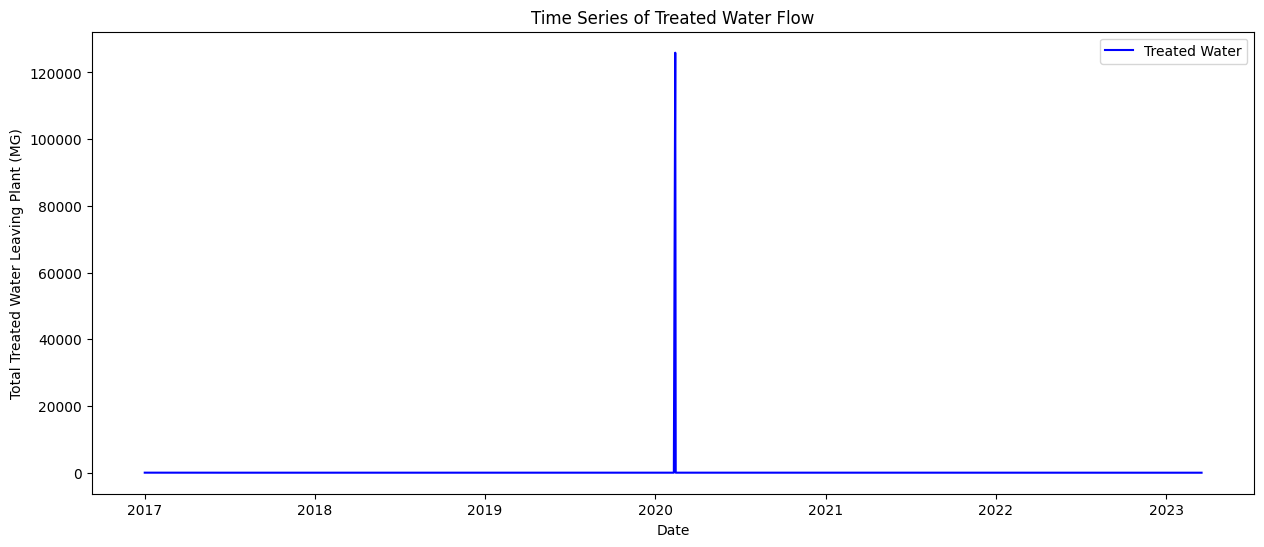

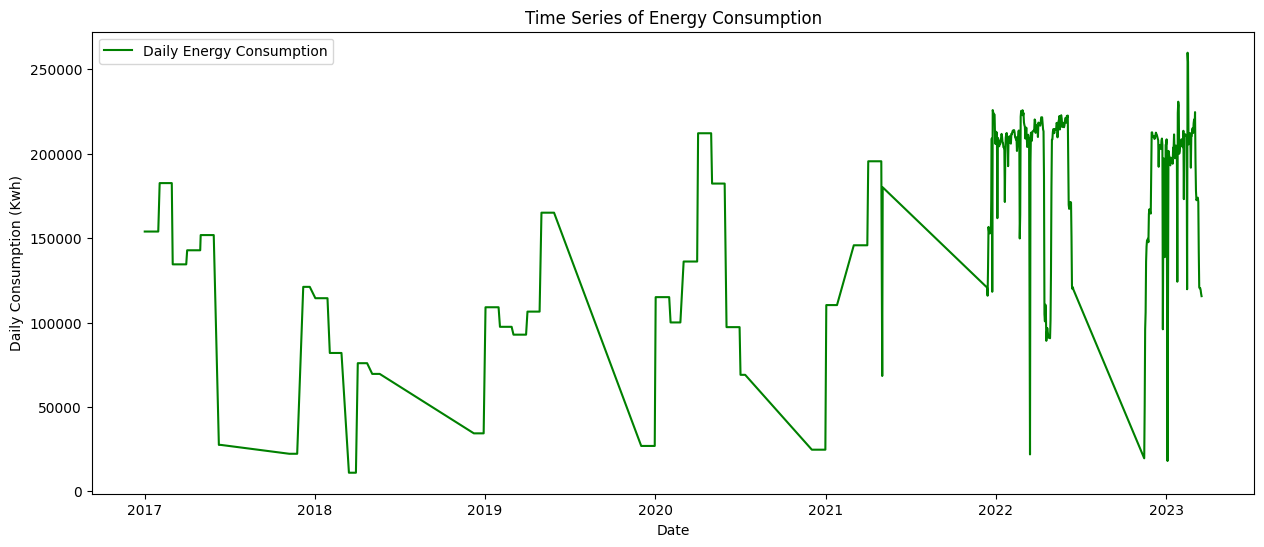

In [13]:
# Plot for Total Treated Water Leaving Plant
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['TotalTreated water leaving plant,MG'], label='Treated Water', color='blue')
plt.xlabel('Date')
plt.ylabel('Total Treated Water Leaving Plant (MG)')
plt.title('Time Series of Treated Water Flow')
plt.legend()
plt.show()

# Plot for Adjusted Daily Consumption
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['Adjusted Daily Consumption, Kwh'], label='Daily Energy Consumption', color='green')
plt.xlabel('Date')
plt.ylabel('Daily Consumption (Kwh)')
plt.title('Time Series of Energy Consumption')
plt.legend()
plt.show()


In [14]:
# Removing outliers beyond 99th percentile
for col in ['TotalTreated water leaving plant,MG', 'Total Raw water to plant,MG', 'Peak demand into distribution,MDG']:
    cap = data[col].quantile(0.99)
    data = data[data[col] <= cap]

In [15]:
data.head()

,Date,Year,Day of the Month,"Rain fall,Inches","TotalTreated water leaving plant,MG",Hours Plant in operation,"Total Raw water to plant,MG","Backwas,Thousand Gallons","Peak demand into distribution,MDG",Nomeasurements Recorded,...,"Adjusted Daily Consumption, Kwh",Month_December,Month_Feb,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November
0,2017-01-01,2017,1,0.0,15.38,24.0,27.14,3043.0,15.29,6.0,...,153910,0,0,0,1,0,0,0,0,0
1,2017-01-02,2017,2,0.0,15.56,24.0,27.13,3076.0,15.47,6.0,...,153910,0,0,0,1,0,0,0,0,0
2,2017-01-03,2017,3,0.0,15.74,24.0,27.14,3110.0,15.60,6.0,...,153910,0,0,0,1,0,0,0,0,0
3,2017-01-04,2017,4,0.0,16.02,24.0,26.83,3095.0,15.62,6.0,...,153910,0,0,0,1,0,0,0,0,0
4,2017-01-05,2017,5,0.0,15.25,24.0,26.63,3038.0,15.50,6.0,...,153910,0,0,0,1,0,0,0,0,0


In [16]:
# Checking for non-numeric values

# Function to check if a string contains only digits and periods
def check_string(value):
    for char in str(value):
        if char not in '1234567890.':
            return False
    return True

# Dictionary to store columns with non-integer or non-period characters
columns_with_non_integers = {}

# Loop through each column that is supposed to be numeric after preprocessing
for col in data:  # Replace with your actual numeric columns
    if col != "Date":
      # Check each value in the column
      for value in data[col]:
          if not check_string(value):
              if col not in columns_with_non_integers:
                  columns_with_non_integers[col] = []
              columns_with_non_integers[col].append(value)

# Display the columns and their non-integer values
for col, values in columns_with_non_integers.items():
    print(f"Column '{col}' has non-integer values: {values[:10]}...")  # Display only the first 10 non-integer values

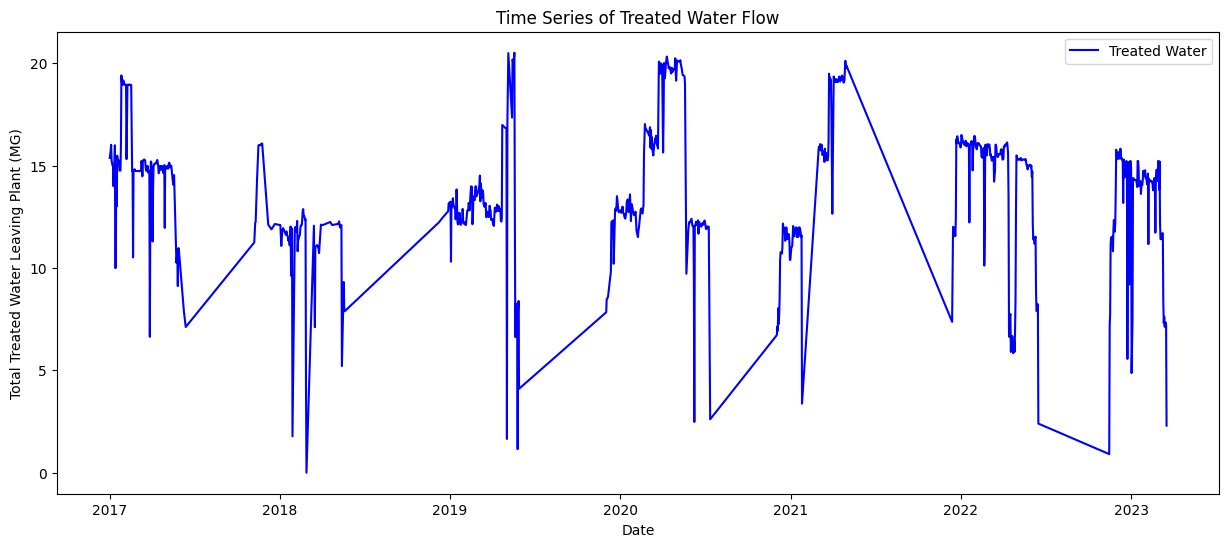

In [17]:
# Plot for Total Treated Water Leaving Plant
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['TotalTreated water leaving plant,MG'], label='Treated Water', color='blue')
plt.xlabel('Date')
plt.ylabel('Total Treated Water Leaving Plant (MG)')
plt.title('Time Series of Treated Water Flow')
plt.legend()
plt.show()


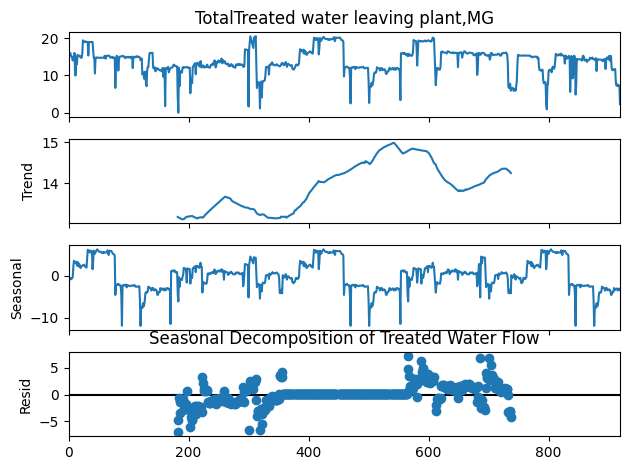

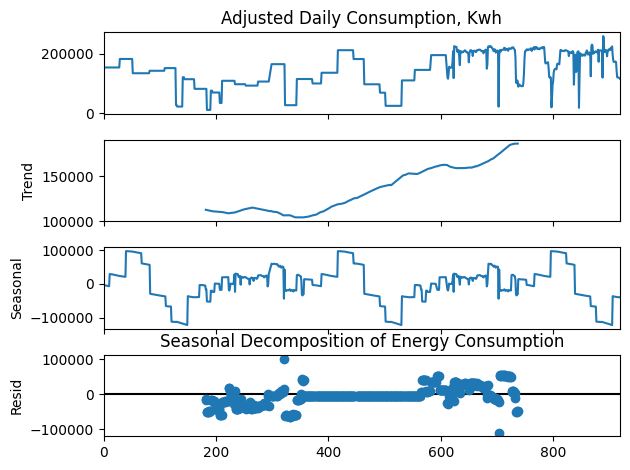

In [18]:
# Seasonal Decomposition for Treated Water
decomposition_treated = seasonal_decompose(data['TotalTreated water leaving plant,MG'], period=365)
decomposition_treated.plot()
plt.title('Seasonal Decomposition of Treated Water Flow')
plt.show()

# Seasonal Decomposition for Raw Water
decomposition_raw = seasonal_decompose(data['Adjusted Daily Consumption, Kwh'], period=365)
decomposition_raw.plot()
plt.title('Seasonal Decomposition of Energy Consumption')
plt.show()


In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition for Treated Water

treated_seasonal = decomposition_treated.seasonal
treated_trend = decomposition_treated.trend
treated_residual = decomposition_treated.resid

# Perform seasonal decomposition for Raw Water
raw_seasonal = decomposition_raw.seasonal
raw_trend = decomposition_raw.trend
raw_residual = decomposition_raw.resid

# Create DataFrames to hold the decomposition components for each target variable
decomposition_treated_df = pd.DataFrame({
    'Date': data['Date'],
    'Seasonal': treated_seasonal,
    'Trend': treated_trend,
    'Residual': treated_residual
})

decomposition_raw_df = pd.DataFrame({
    'Date': data['Date'],
    'Seasonal': raw_seasonal,
    'Trend': raw_trend,
    'Residual': raw_residual
})

# Display the first few rows of each DataFrame
print("Decomposition Components for Treated Water:")
print(decomposition_treated_df.head())

print("\nDecomposition Components for Energy Consumption:")
print(decomposition_raw_df.head())



# Create DataFrames to hold the decomposition components for each target variable
decomposition_treated_df = pd.DataFrame({
    'Date': data['Date'],
    'Seasonal': treated_seasonal,
    'Trend': treated_trend,
    'Residual': treated_residual
})

decomposition_raw_df = pd.DataFrame({
    'Date': data['Date'],
    'Seasonal': raw_seasonal,
    'Trend': raw_trend,
    'Residual': raw_residual
})

# Display the first few non-NaN rows of each DataFrame
print("Decomposition Components for Treated Water:")
print(decomposition_treated_df.dropna().head())

print("\nDecomposition Components for Daily Consumption, Kwh:")
print(decomposition_raw_df.dropna().head())



Decomposition Components for Treated Water:
        Date  Seasonal  Trend  Residual
0 2017-01-01 -1.553833    NaN       NaN
1 2017-01-02 -1.463901    NaN       NaN
2 2017-01-03 -0.565001    NaN       NaN
3 2017-01-04 -0.529757    NaN       NaN
4 2017-01-05 -0.746251    NaN       NaN

Decomposition Components for Energy Consumption:
        Date     Seasonal  Trend  Residual
0 2017-01-01 -3338.798769    NaN       NaN
1 2017-01-02 -3513.639865    NaN       NaN
2 2017-01-03 -3882.891920    NaN       NaN
3 2017-01-04 -4252.143974    NaN       NaN
4 2017-01-05 -4621.396029    NaN       NaN
Decomposition Components for Treated Water:
          Date  Seasonal      Trend  Residual
182 2018-02-26 -4.387905  13.188079 -4.660173
183 2018-02-27 -6.135032  13.178305 -7.043273
184 2018-03-15 -0.373153  13.168403 -0.725249
185 2018-03-17 -2.676360  13.160495 -3.374134
186 2018-03-18 -0.755979  13.151980 -1.366001

Decomposition Components for Daily Consumption, Kwh:
          Date      Seasonal      

In [20]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary')
    else:
        print('Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ')

# Apply the test on your time series data
adf_test(data['TotalTreated water leaving plant,MG'])
adf_test(data['Adjusted Daily Consumption, Kwh'])


ADF Statistic: -5.201429236786586
p-value: 8.733204463942472e-06
Critical Values: {'1%': -3.437743827988169, '5%': -2.864803950716061, '10%': -2.5685079558676054}
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
ADF Statistic: -3.6997913428386013
p-value: 0.004116090045966723
Critical Values: {'1%': -3.4377354773501243, '5%': -2.8648002689134535, '10%': -2.5685059946940183}
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [21]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

In [22]:
# Split sizes
train_size = int(len(data) * 0.5)  # 50% for training

# Train-Test Split
train, test = data[:train_size], data[train_size:]

# Prepare data for machine learning models for actual values

# Training data
X_train_actual = train.drop(['Date', 'TotalTreated water leaving plant,MG', 'Adjusted Daily Consumption, Kwh'], axis=1)
y_train_treated_actual = train['TotalTreated water leaving plant,MG']
y_train_energy_actual = train['Adjusted Daily Consumption, Kwh']

# Test data
X_test_actual = test.drop(['Date', 'TotalTreated water leaving plant,MG', 'Adjusted Daily Consumption, Kwh'], axis=1)
y_test_treated_actual = test['TotalTreated water leaving plant,MG']
y_test_energy_actual = test['Adjusted Daily Consumption, Kwh']

print("Training set size:", len(X_train_actual))
print("Test set size:", len(X_test_actual))

Training set size: 447
Test set size: 447


In [23]:
# Define a function for training machine learning models
def train_ml_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# Define a function for training SARIMA models
def train_sarima_model(y_train, order, seasonal_order):
    try:
        sarima_model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
        sarima_fit = sarima_model.fit(disp=False)
        return sarima_fit
    except Exception as e:
        print("Error fitting SARIMA model:", str(e))
        return None

# Machine Learning Model Training for Treated Water
rf_model_treated = train_ml_model(RandomForestRegressor(), X_train_actual, y_train_treated_actual)
gb_model_treated = train_ml_model(GradientBoostingRegressor(), X_train_actual, y_train_treated_actual)

# Machine Learning Model Training for Energy Consumption
rf_model_energy = train_ml_model(RandomForestRegressor(), X_train_actual, y_train_energy_actual)
gb_model_energy = train_ml_model(GradientBoostingRegressor(), X_train_actual, y_train_energy_actual)

# SARIMA Model Training for Treated Water
sarima_order = (1, 1, 1)
sarima_seasonal_order = (1, 1, 1, 12)
sarima_fit_treated = train_sarima_model(y_train_treated_actual, sarima_order, sarima_seasonal_order)

# SARIMA Model Training for Energy Consumption
sarima_fit_energy = train_sarima_model(y_train_energy_actual, sarima_order, sarima_seasonal_order)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  w

In [24]:
# Making Predictions for Actual Values on Test Set
rf_pred_treated_test = rf_model_treated.predict(X_test_actual)
gb_pred_treated_test = gb_model_treated.predict(X_test_actual)
rf_pred_energy_test = rf_model_energy.predict(X_test_actual)
gb_pred_energy_test = gb_model_energy.predict(X_test_actual)

# Making SARIMA Predictions for Actual Values on Test Set
sarima_pred_treated_test = sarima_fit_treated.predict(start=len(y_train_treated_actual), end=len(y_train_treated_actual) + len(y_test_treated_actual) - 1, dynamic=True)
sarima_pred_energy_test = sarima_fit_energy.predict(start=len(y_train_energy_actual), end=len(y_train_energy_actual) + len(y_test_energy_actual) - 1, dynamic=True)

# Convert SARIMA predictions to numpy arrays for consistency
sarima_pred_treated_test = np.array(sarima_pred_treated_test)
sarima_pred_energy_test = np.array(sarima_pred_energy_test)

# Ensemble Predictions for Actual Values on Test Set
treated_test_outputs = [rf_pred_treated_test, gb_pred_treated_test, sarima_pred_treated_test]
energy_test_outputs = [rf_pred_energy_test, gb_pred_energy_test, sarima_pred_energy_test]
ensemble_pred_treated_test = np.mean(treated_test_outputs, axis=0)
ensemble_pred_energy_test = np.mean(energy_test_outputs, axis=0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np

def error(y_true, y_pred, threshold=0.5):
    """
    Calculate the error rate based on a given threshold.
    The function returns the proportion of predictions that are off by more than the threshold.
    """
    return np.mean(np.abs(y_true - y_pred) > threshold)

def evaluate_predictions(y_true, y_pred, model_name):
    """
    Evaluate and print RMSE, MAE, and Error Rate for a given model's predictions.
    """
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    err_rate = error(y_true, y_pred)

    print(f"=== {model_name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Error Rate: {err_rate:.4f}\n")
    return rmse, mae, err_rate

def main():
    # Evaluating Water Flow Predictions
    print("Evaluations for Water Flow:\n")
    evaluate_predictions(y_test_treated_actual, rf_pred_treated_test, "Random Forest")
    evaluate_predictions(y_test_treated_actual, gb_pred_treated_test, "Gradient Boosting")
    evaluate_predictions(y_test_treated_actual, sarima_pred_treated_test, "SARIMA")
    evaluate_predictions(y_test_treated_actual, ensemble_pred_treated_test, "Ensemble")

    # Evaluating Energy Consumption Predictions
    print("Evaluations for Energy Consumption:\n")
    evaluate_predictions(y_test_energy_actual, rf_pred_energy_test, "Random Forest")
    evaluate_predictions(y_test_energy_actual, gb_pred_energy_test, "Gradient Boosting")
    evaluate_predictions(y_test_energy_actual, sarima_pred_energy_test, "SARIMA")
    evaluate_predictions(y_test_energy_actual, ensemble_pred_energy_test, "Ensemble")

# Run the evaluations
main()


Evaluations for Water Flow:

=== Random Forest ===
RMSE: 1.4470
MAE: 0.6833
Error Rate: 0.2729

=== Gradient Boosting ===
RMSE: 1.6364
MAE: 0.8081
Error Rate: 0.2908

=== SARIMA ===
RMSE: 3.5344
MAE: 3.0474
Error Rate: 0.9463

=== Ensemble ===
RMSE: 1.8149
MAE: 1.2984
Error Rate: 0.7987

Evaluations for Energy Consumption:

=== Random Forest ===
RMSE: 60363.4406
MAE: 48963.9185
Error Rate: 1.0000

=== Gradient Boosting ===
RMSE: 56282.6728
MAE: 47270.0929
Error Rate: 1.0000

=== SARIMA ===
RMSE: 138545.8361
MAE: 126090.5468
Error Rate: 1.0000

=== Ensemble ===
RMSE: 39094.8911
MAE: 28735.0707
Error Rate: 1.0000



In [26]:
# Split sizes
train_size = int(len(data) * 0.6)  # 70% for training
validation_size = int(len(data) * 0.2)  # 20% for validation

# Train-Validation-Test Split
train, temp = data[:train_size], data[train_size:]
validation, test = temp[:validation_size], temp[validation_size:]

# Prepare data for machine learning models for actual values

# Training data
X_train_actual = train.drop(['Date', 'TotalTreated water leaving plant,MG', 'Adjusted Daily Consumption, Kwh'], axis=1)
y_train_treated_actual = train['TotalTreated water leaving plant,MG']
y_train_energy_actual = train['Adjusted Daily Consumption, Kwh']

# Validation data
X_validation_actual = validation.drop(['Date', 'TotalTreated water leaving plant,MG', 'Adjusted Daily Consumption, Kwh'], axis=1)
y_validation_treated_actual = validation['TotalTreated water leaving plant,MG']
y_validation_energy_actual = validation['Adjusted Daily Consumption, Kwh']

# Test data
X_test_actual = test.drop(['Date', 'TotalTreated water leaving plant,MG', 'Adjusted Daily Consumption, Kwh'], axis=1)
y_test_treated_actual = test['TotalTreated water leaving plant,MG']
y_test_energy_actual = test['Adjusted Daily Consumption, Kwh']

print("Training set size:", len(X_train_actual))
print("Validation set size:", len(X_validation_actual))
print("Test set size:", len(X_test_actual))


Training set size: 536
Validation set size: 178
Test set size: 180


In [27]:
X_train_actual

,Year,Day of the Month,"Rain fall,Inches",Hours Plant in operation,"Total Raw water to plant,MG","Backwas,Thousand Gallons","Peak demand into distribution,MDG",Nomeasurements Recorded,No Measuremnts Required,"Average Daily Turbidity,NTU",...,"Log Inactivation,Viruses",Month_December,Month_Feb,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November
0,2017,1,0.0,24.0,27.1400,3043.00,15.2900,6.0,6.0,0.0200,...,472.74,0,0,0,1,0,0,0,0,0
1,2017,2,0.0,24.0,27.1300,3076.00,15.4700,6.0,6.0,0.0200,...,405.58,0,0,0,1,0,0,0,0,0
2,2017,3,0.0,24.0,27.1400,3110.00,15.6000,6.0,6.0,0.0200,...,439.79,0,0,0,1,0,0,0,0,0
3,2017,4,0.0,24.0,26.8300,3095.00,15.6200,6.0,6.0,0.0200,...,468.74,0,0,0,1,0,0,0,0,0
4,2017,5,0.0,24.0,26.6300,3038.00,15.5000,6.0,6.0,0.0200,...,443.77,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,2021,21,0.0,24.0,20.6186,2842.88,12.1703,6.0,6.0,0.0622,...,679.64,0,0,0,1,0,0,0,0,0
550,2021,22,0.0,24.0,20.3602,2863.93,12.1798,6.0,6.0,0.0602,...,759.80,0,0,0,1,0,0,0,0,0
551,2021,23,0.0,24.0,20.3404,2881.28,11.7530,6.0,6.0,0.0584,...,813.61,0,0,0,1,0,0,0,0,0
552,2021,24,0.0,24.0,20.2560,2898.97,11.8229,6.0,6.0,0.0597,...,736.77,0,0,0,1,0,0,0,0,0


In [28]:

# Machine Learning Model Training for Treated Water
rf_model_treated = RandomForestRegressor()
rf_model_treated.fit(X_train_actual, y_train_treated_actual)

gb_model_treated = GradientBoostingRegressor()
gb_model_treated.fit(X_train_actual, y_train_treated_actual)

# Machine Learning Model Training for Energy Consumption
rf_model_energy = RandomForestRegressor()
rf_model_energy.fit(X_train_actual, y_train_energy_actual)

gb_model_energy = GradientBoostingRegressor()
gb_model_energy.fit(X_train_actual, y_train_energy_actual)

# SARIMA Model Training for Treated Water
try:
    sarima_model_treated = SARIMAX(y_train_treated_actual, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fit_treated = sarima_model_treated.fit(disp=False)
except Exception as e:
    print("Error fitting SARIMA model for Treated Water:", str(e))

# SARIMA Model Training for Energy Consumption
try:
    sarima_model_energy = SARIMAX(y_train_energy_actual, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fit_energy = sarima_model_energy.fit(disp=False)
except Exception as e:
    print("Error fitting SARIMA model for Energy Consumption:", str(e))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  w

In [29]:
# Making Predictions for Actual Values on Validation Set
rf_pred_treated_validation = rf_model_treated.predict(X_validation_actual)
gb_pred_treated_validation = gb_model_treated.predict(X_validation_actual)
rf_pred_energy_validation = rf_model_energy.predict(X_validation_actual)
gb_pred_energy_validation = gb_model_energy.predict(X_validation_actual)

sarima_pred_treated_validation = sarima_fit_treated.predict(len(y_train_treated_actual), len(y_train_treated_actual) + len(y_validation_treated_actual) - 1)
sarima_pred_energy_validation = sarima_fit_energy.predict(len(y_train_energy_actual), len(y_train_energy_actual) + len(y_validation_energy_actual) - 1)

# Convert SARIMA predictions to numpy arrays for consistency
sarima_pred_treated_validation = np.array(sarima_pred_treated_validation)
sarima_pred_energy_validation = np.array(sarima_pred_energy_validation)

# Ensemble Predictions for Actual Values on Validation Set
treated_validation_outputs = [rf_pred_treated_validation, gb_pred_treated_validation, sarima_pred_treated_validation]
energy_validation_outputs = [rf_pred_energy_validation, gb_pred_energy_validation, sarima_pred_energy_validation]
ensemble_pred_treated_validation = np.mean(treated_validation_outputs, axis=0)
ensemble_pred_energy_validation = np.mean(energy_validation_outputs, axis=0)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [30]:
def error(y_true, y_pred, threshold=0.5):
    """
    Calculate the error rate based on a given threshold.
    The function returns the proportion of predictions that are off by more than the threshold.
    """
    return np.mean(np.abs(y_true - y_pred) > threshold)

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def calculate_metrics(y_true, y_pred, model_name, target_name):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    error_rate = calculate_error_rate(y_true, y_pred)  # Define this function!

    print(f"=== {model_name} for {target_name} ===")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"Error Rate: {error_rate:.2f}%\n")

# For example: calculate_error_rate can be a relative error, defined as:
def calculate_error_rate(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error (MAPE)

# Predictions and Model Names for Treated Water on Validation Set
treated_preds = [rf_pred_treated_validation, gb_pred_treated_validation, sarima_pred_treated_validation, ensemble_pred_treated_validation]
treated_model_names = ['RF', 'GB', 'SARIMA', 'Ensemble']

for model_name, pred in zip(treated_model_names, treated_preds):
    calculate_metrics(y_validation_treated_actual, pred, model_name, 'Treated Water Validation')

# Predictions and Model Names for Energy Consumption on Validation Set
energy_preds = [rf_pred_energy_validation, gb_pred_energy_validation, sarima_pred_energy_validation, ensemble_pred_energy_validation]
energy_model_names = ['RF', 'GB', 'SARIMA', 'Ensemble']

for model_name, pred in zip(energy_model_names, energy_preds):
    calculate_metrics(y_validation_energy_actual, pred, model_name, 'Energy Consumption Validation')

=== RF for Treated Water Validation ===
RMSE: 1.04
MAE: 0.58
Error Rate: 4.77%

=== GB for Treated Water Validation ===
RMSE: 1.12
MAE: 0.52
Error Rate: 4.58%

=== SARIMA for Treated Water Validation ===
RMSE: 9.12
MAE: 8.78
Error Rate: 54.26%

=== Ensemble for Treated Water Validation ===
RMSE: 3.01
MAE: 2.90
Error Rate: 18.37%

=== RF for Energy Consumption Validation ===
RMSE: 64580.00
MAE: 54235.23
Error Rate: 30.11%

=== GB for Energy Consumption Validation ===
RMSE: 58971.82
MAE: 48239.19
Error Rate: 27.17%

=== SARIMA for Energy Consumption Validation ===
RMSE: 75092.56
MAE: 70619.03
Error Rate: 38.11%

=== Ensemble for Energy Consumption Validation ===
RMSE: 63829.56
MAE: 56898.53
Error Rate: 31.21%



# Hyper Parameter Tunning on the Gradient Boost Model for Energy Consumption

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Define the parameter grid
param_grid_energy = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [None, 'sqrt', 'log2', 'auto'],
    'subsample': [0.5, 0.75, 1.0]
}

# Initialize Gradient Boosting Regressor
gb_energy = GradientBoostingRegressor()

# Create the grid search object
grid_search_energy = GridSearchCV(estimator=gb_energy, param_grid=param_grid_energy,
                                  scoring='neg_mean_squared_error',
                                  cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the energy data
grid_search_energy.fit(X_train_actual, y_train_energy_actual)

# Print the best parameters and estimator
print("Best parameters found for energy data: ", grid_search_energy.best_params_)
print("Best cross-validation score (RMSE) for energy data: ", sqrt(-grid_search_energy.best_score_))

# Get the best estimator for energy data
best_gb_energy = grid_search_energy.best_estimator_


Fitting 3 folds for each of 28800 candidates, totalling 86400 fits
Best parameters found for energy data:  {'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100, 'subsample': 0.5}
Best cross-validation score (RMSE) for energy data:  36426.50076916853


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

In [33]:
best_gb_energy=best_gb_energy.fit(X_train_actual, y_train_energy_actual)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

# Validation Curve for the best GB model on Energy Consumption¶

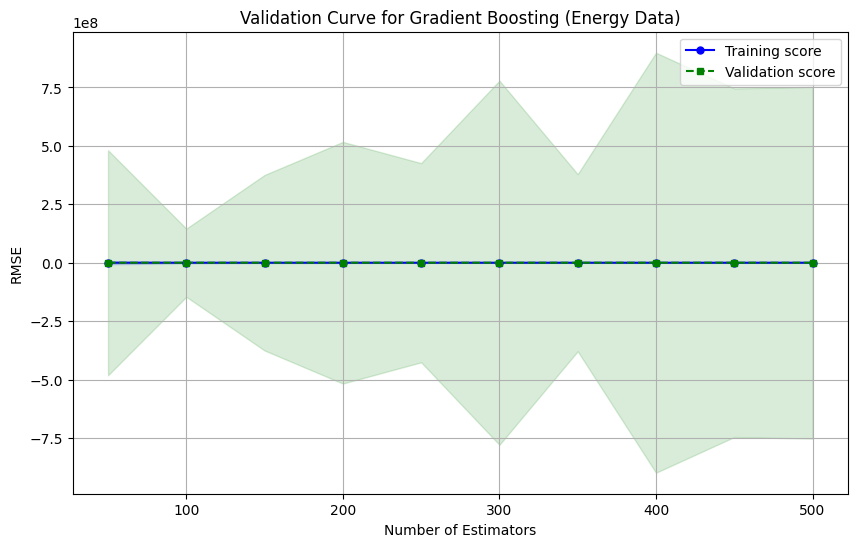

In [34]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Assuming best_gb_energy and the datasets (X_train_actual, y_train_energy_actual) are properly defined

# Define the range of 'n_estimators' to explore
param_range = np.linspace(50, 500, 10).astype(int)

# Compute the validation curve
train_scores, test_scores = validation_curve(
    estimator=GradientBoostingRegressor(learning_rate=best_gb_energy.learning_rate,
                                        max_depth=best_gb_energy.max_depth,
                                        min_samples_split=best_gb_energy.min_samples_split,
                                        min_samples_leaf=best_gb_energy.min_samples_leaf,
                                        max_features=best_gb_energy.max_features,
                                        subsample=best_gb_energy.subsample),
    X=X_train_actual,
    y=y_train_energy_actual,
    param_name='n_estimators',
    param_range=param_range,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_mean)
test_rmse = np.sqrt(-test_mean)

# Plot the validation curve
plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(param_range, train_rmse, color='blue', marker='o', markersize=5, label='Training score')

# Plot training score bands (mean +/- std)
plt.fill_between(param_range, train_rmse - train_std, train_rmse + train_std, alpha=0.15, color='blue')

# Plot validation scores
plt.plot(param_range, test_rmse, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')

# Plot validation score bands (mean +/- std)
plt.fill_between(param_range, test_rmse - test_std, test_rmse + test_std, alpha=0.15, color='green')

plt.title('Validation Curve for Gradient Boosting (Energy Data)')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Hyper Parameter Tunning on the Random Forest Model for Energy Consumption

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define the parameter grid for RandomForestRegressor
param_grid_energy_rf = {
     'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2', 0.3, 0.5]
}

# Initialize RandomForestRegressor
rf_energy = RandomForestRegressor()

# Create the grid search object
grid_search_energy_rf = GridSearchCV(estimator=rf_energy, param_grid=param_grid_energy_rf,
                                     scoring='neg_mean_squared_error',
                                     cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the energy data
grid_search_energy_rf.fit(X_train_actual, y_train_energy_actual)

# Print the best parameters and estimator
print("Best parameters found for energy data: ", grid_search_energy_rf.best_params_)
print("Best cross-validation score (RMSE) for energy data: ", np.sqrt(-grid_search_energy_rf.best_score_))

# Get the best estimator for energy data
best_rf_energy = grid_search_energy_rf.best_estimator_
best_rf_energy.fit(X_train_actual, y_train_energy_actual)


Fitting 3 folds for each of 8750 candidates, totalling 26250 fits
Best parameters found for energy data:  {'bootstrap': True, 'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score (RMSE) for energy data:  41227.58513200866


RandomForestRegressor(max_features=0.3, min_samples_leaf=6, n_estimators=50)

# Validation Curve for the best RF model on Energy Consumption

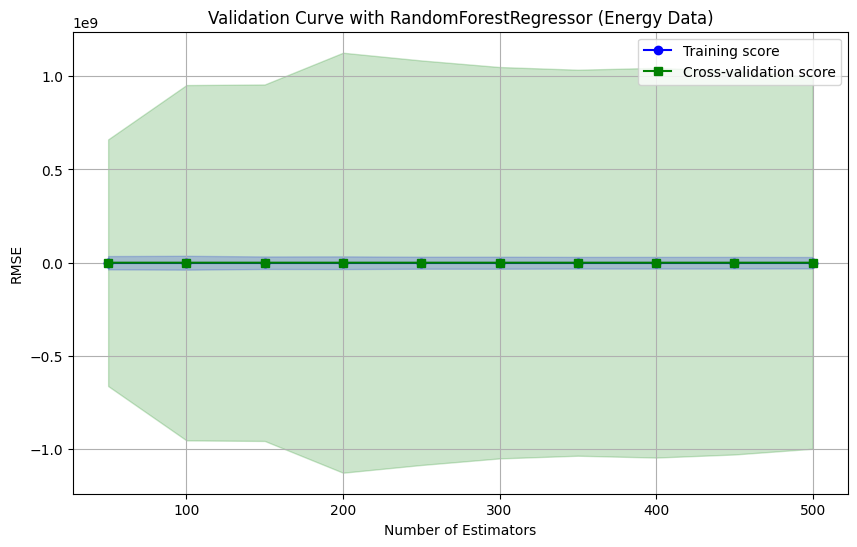

In [36]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train_actual and y_train_energy_actual are your training datasets

# Define the range of 'n_estimators' to explore
param_range = np.arange(50, 550, 50)

# Compute the validation curve
train_scores, test_scores = validation_curve(
    estimator=RandomForestRegressor(max_depth=best_rf_energy.max_depth,
                                    min_samples_split=best_rf_energy.min_samples_split,
                                    min_samples_leaf=best_rf_energy.min_samples_leaf,
                                    bootstrap=best_rf_energy.bootstrap,
                                    max_features=best_rf_energy.max_features,
                                    random_state=42),  # Ensure reproducibility
    X=X_train_actual,
    y=y_train_energy_actual,
    param_name='n_estimators',
    param_range=param_range,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate mean and standard deviation for training and test set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_mean)
test_rmse = np.sqrt(-test_mean)

# Plot the validation curve
plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(param_range, train_rmse, label='Training score', color='blue', marker='o')
plt.fill_between(param_range, train_rmse - train_std, train_rmse + train_std, color='blue', alpha=0.2)

# Plot validation scores
plt.plot(param_range, test_rmse, label='Cross-validation score', color='green', marker='s')
plt.fill_between(param_range, test_rmse - test_std, test_rmse + test_std, color='green', alpha=0.2)

plt.title('Validation Curve with RandomForestRegressor (Energy Data)')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Hyper Parameter Tunning on the Gradient Boost Model for Treated Water

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

# Define the parameter grid for Gradient Boosting
param_grid_gb_treated = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['auto', 'sqrt', 'log2', 0.3, 0.5],
    'subsample': [0.5, 0.75, 1.0]
}

# Initialize Gradient Boosting Regressor
gb_treated = GradientBoostingRegressor()

# Create the grid search object
grid_search_gb_treated = GridSearchCV(estimator=gb_treated, param_grid=param_grid_gb_treated,
                                      scoring='neg_mean_squared_error',
                                      cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the data
grid_search_gb_treated.fit(X_train_actual, y_train_treated_actual)

# Print the best parameters and estimator
print("Best parameters found for Gradient Boosting: ", grid_search_gb_treated.best_params_)
print("Best cross-validation score (RMSE) for Gradient Boosting: ", np.sqrt(-grid_search_gb_treated.best_score_))

# Get the best estimator for Gradient Boosting
best_gb_treated = grid_search_gb_treated.best_estimator_
best_gb_treated.fit(X_train_actual, y_train_treated_actual)

Fitting 3 folds for each of 56250 candidates, totalling 168750 fits
Best parameters found for Gradient Boosting:  {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 100, 'subsample': 0.5}
Best cross-validation score (RMSE) for Gradient Boosting:  0.9776368738721057


GradientBoostingRegressor(max_depth=4, max_features=0.3, min_samples_leaf=4,
                          min_samples_split=20, subsample=0.5)

# Validation Curve for the best GB model on Treated Water

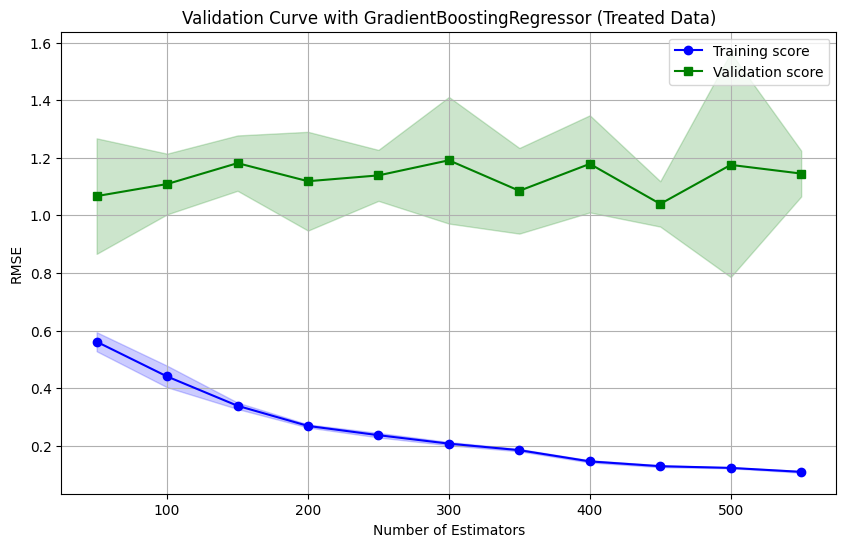

In [ ]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the range of 'n_estimators' to explore
param_range = np.arange(50, 551, 50)

# Compute the validation curve
train_scores, test_scores = validation_curve(
    estimator=GradientBoostingRegressor(learning_rate=best_gb_treated.learning_rate,
                                        max_depth=best_gb_treated.max_depth,
                                        min_samples_split=best_gb_treated.min_samples_split,
                                        min_samples_leaf=best_gb_treated.min_samples_leaf,
                                        max_features=best_gb_treated.max_features,
                                        subsample=best_gb_treated.subsample),
    X=X_train_actual,
    y=y_train_treated_actual,
    param_name='n_estimators',
    param_range=param_range,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_mean)
test_rmse = np.sqrt(-test_mean)

# Plot the validation curve
plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(param_range, train_rmse, label='Training score', color='blue', marker='o')
plt.fill_between(param_range, train_rmse - train_std, train_rmse + train_std, color='blue', alpha=0.2)

# Plot test scores
plt.plot(param_range, test_rmse, label='Validation score', color='green', marker='s')
plt.fill_between(param_range, test_rmse - test_std, test_rmse + test_std, color='green', alpha=0.2)

plt.title('Validation Curve with GradientBoostingRegressor (Treated Data)')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Hyper Parameter Tunning on the Random Forest Model for Treated Water

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid for Random Forest
param_grid_rf_treated = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2', 0.3, 0.5]
}

# Initialize Random Forest Regressor
rf_treated = RandomForestRegressor()

# Create the grid search object
grid_search_rf_treated = GridSearchCV(estimator=rf_treated, param_grid=param_grid_rf_treated,
                                      scoring='neg_mean_squared_error',
                                      cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the data
grid_search_rf_treated.fit(X_train_actual, y_train_treated_actual)

# Print the best parameters and estimator
print("Best parameters found for Random Forest: ", grid_search_rf_treated.best_params_)
print("Best cross-validation score (RMSE) for Random Forest: ", np.sqrt(-grid_search_rf_treated.best_score_))

# Get the best estimator for Random Forest
best_rf_treated = grid_search_rf_treated.best_estimator_
best_rf_treated.fit(X_train_actual, y_train_treated_actual)


Fitting 3 folds for each of 8750 candidates, totalling 26250 fits
Best parameters found for Random Forest:  {'bootstrap': False, 'max_depth': 50, 'max_features': 0.3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score (RMSE) for Random Forest:  1.0742810226648125


RandomForestRegressor(bootstrap=False, max_depth=50, max_features=0.3,
                      min_samples_leaf=2, n_estimators=50)

# Validation Curve for the best GB model on Treated Water

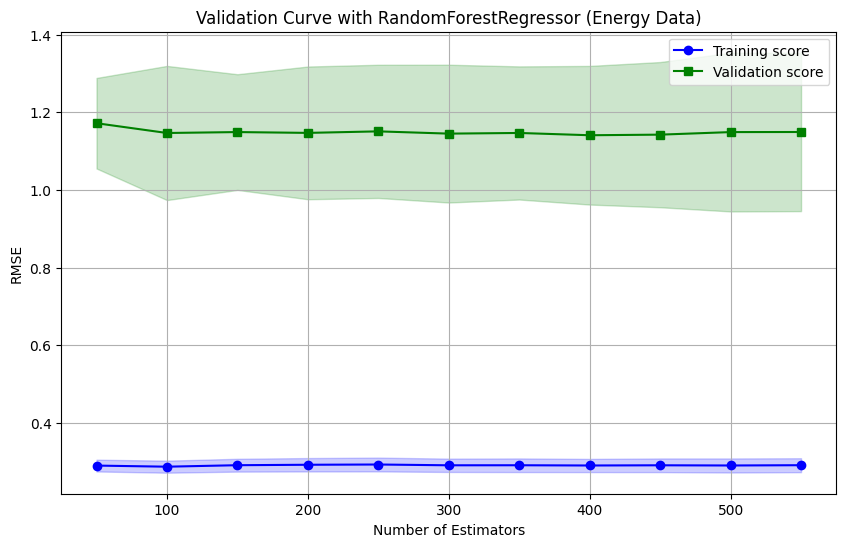

In [ ]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train_actual and y_train_treated_actual are defined and prepared

# Define the range of 'n_estimators' to explore
param_range = np.arange(50, 551, 50)

# Use validation_curve to evaluate the model performance over the defined range of 'n_estimators'
train_scores, test_scores = validation_curve(
    estimator=RandomForestRegressor(max_depth=best_rf_treated.max_depth,
                                    min_samples_split=best_rf_treated.min_samples_split,
                                    min_samples_leaf=best_rf_treated.min_samples_leaf,
                                    bootstrap=best_rf_treated.bootstrap,
                                    max_features=best_rf_treated.max_features,
                                    random_state=42),  # Ensure reproducibility
    X=X_train_actual,
    y=y_train_treated_actual,
    param_name='n_estimators',
    param_range=param_range,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_mean)
test_rmse = np.sqrt(-test_mean)

# Plot the validation curve
plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(param_range, train_rmse, label='Training score', color='blue', marker='o')
plt.fill_between(param_range, train_rmse - train_std, train_rmse + train_std, color='blue', alpha=0.2)

# Plot test (validation) scores
plt.plot(param_range, test_rmse, label='Validation score', color='green', marker='s')
plt.fill_between(param_range, test_rmse - test_std, test_rmse + test_std, color='green', alpha=0.2)

plt.title('Validation Curve with RandomForestRegressor (Energy Data)')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Evaluation of Tuned GB and RF Model for Energy Consumption

In [ ]:

# --- GB Model Predictions and Evaluations ---
y_pred_train_energy_gb = best_gb_energy.predict(X_train_actual)
rmse_train_energy_gb = sqrt(mean_squared_error(y_train_energy_actual, y_pred_train_energy_gb))
mae_train_energy_gb = mean_absolute_error(y_train_energy_actual, y_pred_train_energy_gb)
error_train_energy_gb = error(y_train_energy_actual, y_pred_train_energy_gb)

y_pred_test_energy_gb = best_gb_energy.predict(X_test_actual)
rmse_test_energy_gb = sqrt(mean_squared_error(y_test_energy_actual, y_pred_test_energy_gb))
mae_test_energy_gb = mean_absolute_error(y_test_energy_actual, y_pred_test_energy_gb)
error_test_energy_gb = error(y_test_energy_actual, y_pred_test_energy_gb)

print("=== GB Model Evaluation for Energy Consumption ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_energy_gb:.4f}")
print(f"MAE: {mae_train_energy_gb:.4f}")
print(f"Error Rate: {error_train_energy_gb:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_energy_gb:.4f}")
print(f"MAE: {mae_test_energy_gb:.4f}")
print(f"Error Rate: {error_test_energy_gb:.4f}\n")


# --- RF Model Predictions and Evaluations ---
y_pred_train_energy_rf = best_rf_energy.predict(X_train_actual)
rmse_train_energy_rf = sqrt(mean_squared_error(y_train_energy_actual, y_pred_train_energy_rf))
mae_train_energy_rf = mean_absolute_error(y_train_energy_actual, y_pred_train_energy_rf)
error_train_energy_rf = error(y_train_energy_actual, y_pred_train_energy_rf)

y_pred_test_energy_rf = best_rf_energy.predict(X_test_actual)
rmse_test_energy_rf = sqrt(mean_squared_error(y_test_energy_actual, y_pred_test_energy_rf))
mae_test_energy_rf = mean_absolute_error(y_test_energy_actual, y_pred_test_energy_rf)
error_test_energy_rf = error(y_test_energy_actual, y_pred_test_energy_rf)

print("=== RF Model Evaluation for Energy Consumption ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_energy_rf:.4f}")
print(f"MAE: {mae_train_energy_rf:.4f}")
print(f"Error Rate: {error_train_energy_rf:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_energy_rf:.4f}")
print(f"MAE: {mae_test_energy_rf:.4f}")
print(f"Error Rate: {error_test_energy_rf:.4f}\n")




=== GB Model Evaluation for Energy Consumption ===

--- Training Set ---
RMSE: 3729.0902
MAE: 2695.7567
Error Rate: 1.0000

--- Test Set ---
RMSE: 74041.6833
MAE: 65413.2573
Error Rate: 1.0000

=== RF Model Evaluation for Energy Consumption ===

--- Training Set ---
RMSE: 12802.0982
MAE: 7457.9994
Error Rate: 1.0000

--- Test Set ---
RMSE: 76344.3084
MAE: 69720.6588
Error Rate: 1.0000



# Evaluation of Tuned GB and RF Model for Treated Water

In [ ]:
# --- GB Model Predictions and Evaluations ---
y_pred_train_treated_gb = best_gb_treated.predict(X_train_actual)
rmse_train_treated_gb = sqrt(mean_squared_error(y_train_treated_actual, y_pred_train_treated_gb))
mae_train_treated_gb = mean_absolute_error(y_train_treated_actual, y_pred_train_treated_gb)
error_train_treated_gb = error(y_train_treated_actual, y_pred_train_treated_gb)

y_pred_test_treated_gb = best_gb_treated.predict(X_test_actual)
rmse_test_treated_gb = sqrt(mean_squared_error(y_test_treated_actual, y_pred_test_treated_gb))
mae_test_treated_gb = mean_absolute_error(y_test_treated_actual, y_pred_test_treated_gb)
error_test_treated_gb = error(y_test_treated_actual, y_pred_test_treated_gb)

print("=== GB Model Evaluation for Treated Water ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_treated_gb:.4f}")
print(f"MAE: {mae_train_treated_gb:.4f}")
print(f"Error Rate: {error_train_treated_gb:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_treated_gb:.4f}")
print(f"MAE: {mae_test_treated_gb:.4f}")
print(f"Error Rate: {error_test_treated_gb:.4f}\n")


# --- RF Model Predictions and Evaluations ---
y_pred_train_treated_rf = best_rf_treated.predict(X_train_actual)
rmse_train_treated_rf = sqrt(mean_squared_error(y_train_treated_actual, y_pred_train_treated_rf))
mae_train_treated_rf = mean_absolute_error(y_train_treated_actual, y_pred_train_treated_rf)
error_train_treated_rf = error(y_train_treated_actual, y_pred_train_treated_rf)

y_pred_test_treated_rf = best_rf_treated.predict(X_test_actual)
rmse_test_treated_rf = sqrt(mean_squared_error(y_test_treated_actual, y_pred_test_treated_rf))
mae_test_treated_rf = mean_absolute_error(y_test_treated_actual, y_pred_test_treated_rf)
error_test_treated_rf = error(y_test_treated_actual, y_pred_test_treated_rf)

print("=== RF Model Evaluation for Treated Water ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_treated_rf:.4f}")
print(f"MAE: {mae_train_treated_rf:.4f}")
print(f"Error Rate: {error_train_treated_rf:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_treated_rf:.4f}")
print(f"MAE: {mae_test_treated_rf:.4f}")
print(f"Error Rate: {error_test_treated_rf:.4f}\n")




=== GB Model Evaluation for Treated Water ===

--- Training Set ---
RMSE: 0.4595
MAE: 0.2669
Error Rate: 0.1045

--- Test Set ---
RMSE: 1.2647
MAE: 0.8478
Error Rate: 0.4500

=== RF Model Evaluation for Treated Water ===

--- Training Set ---
RMSE: 0.2922
MAE: 0.1055
Error Rate: 0.0280

--- Test Set ---
RMSE: 1.3861
MAE: 0.9639
Error Rate: 0.6667



# Prediction for Treated Water from best Model

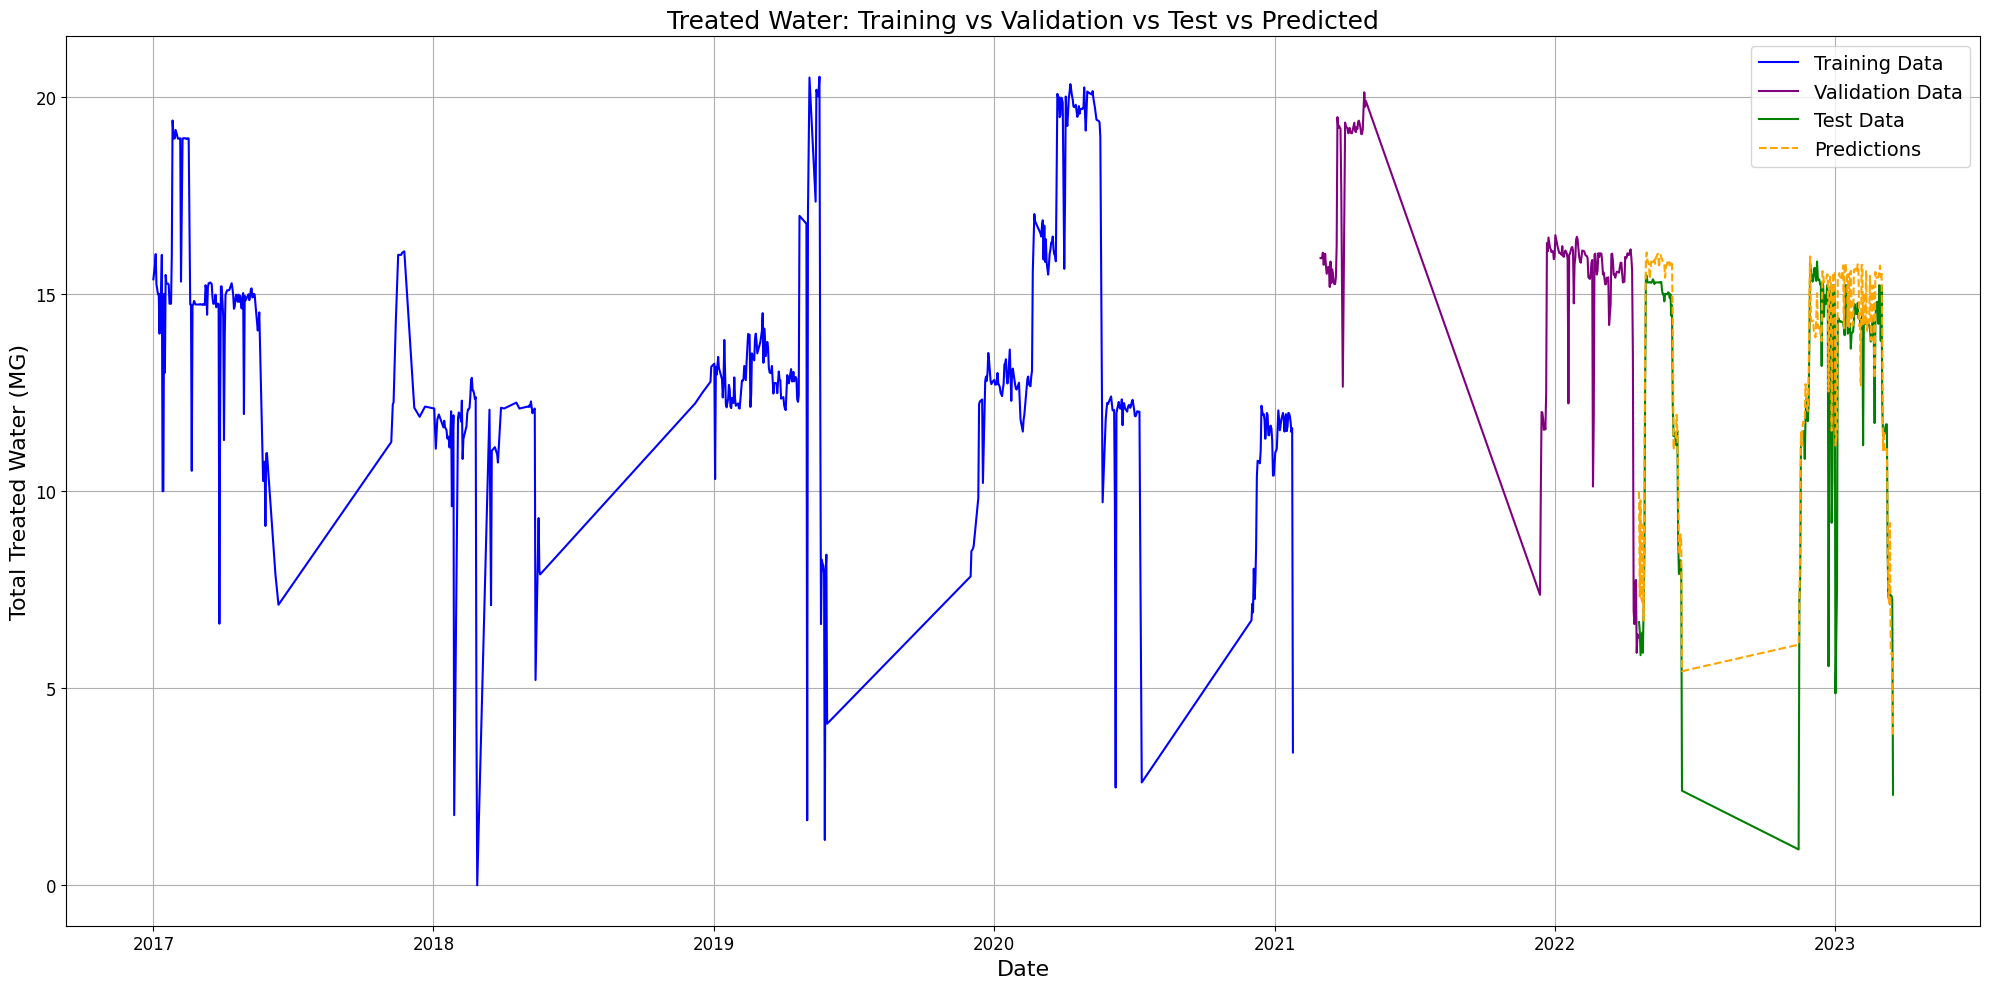

In [ ]:
# Import necessary library
import matplotlib.pyplot as plt

# Plotting function for Treated Water data
def plot_treated_water_predictions(data, y_train, y_validation, y_test, y_pred):
    plt.figure(figsize=(20, 10))

    # Calculate indices for train, validation, and test data for correct plotting
    train_indices = data['Date'][:len(y_train)]
    validation_indices = data['Date'][len(y_train):len(y_train) + len(y_validation)]
    test_indices = data['Date'][len(y_train) + len(y_validation):]

    # Plot Training Data
    plt.plot(train_indices, y_train, label='Training Data', color='blue')

    # Plot Validation Data
    plt.plot(validation_indices, y_validation, label='Validation Data', color='purple')

    # Plot Test Data
    plt.plot(test_indices, y_test, label='Test Data', color='green')

    # Overlay Predicted Data (assuming the predictions are for test data)
    plt.plot(test_indices, y_pred, label='Predictions', color='orange', linestyle='--')

    # Add titles, labels, and legend with increased font sizes
    plt.title('Treated Water: Training vs Validation vs Test vs Predicted', fontsize=18)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Total Treated Water (MG)', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True)

    # Increase the size of tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function with appropriate arguments
plot_treated_water_predictions(data,
                               y_train_treated_actual,
                               y_validation_treated_actual,
                               y_test_treated_actual,
                               y_pred_test_treated_rf)


# Prediction for Energy Consumption from GB Model

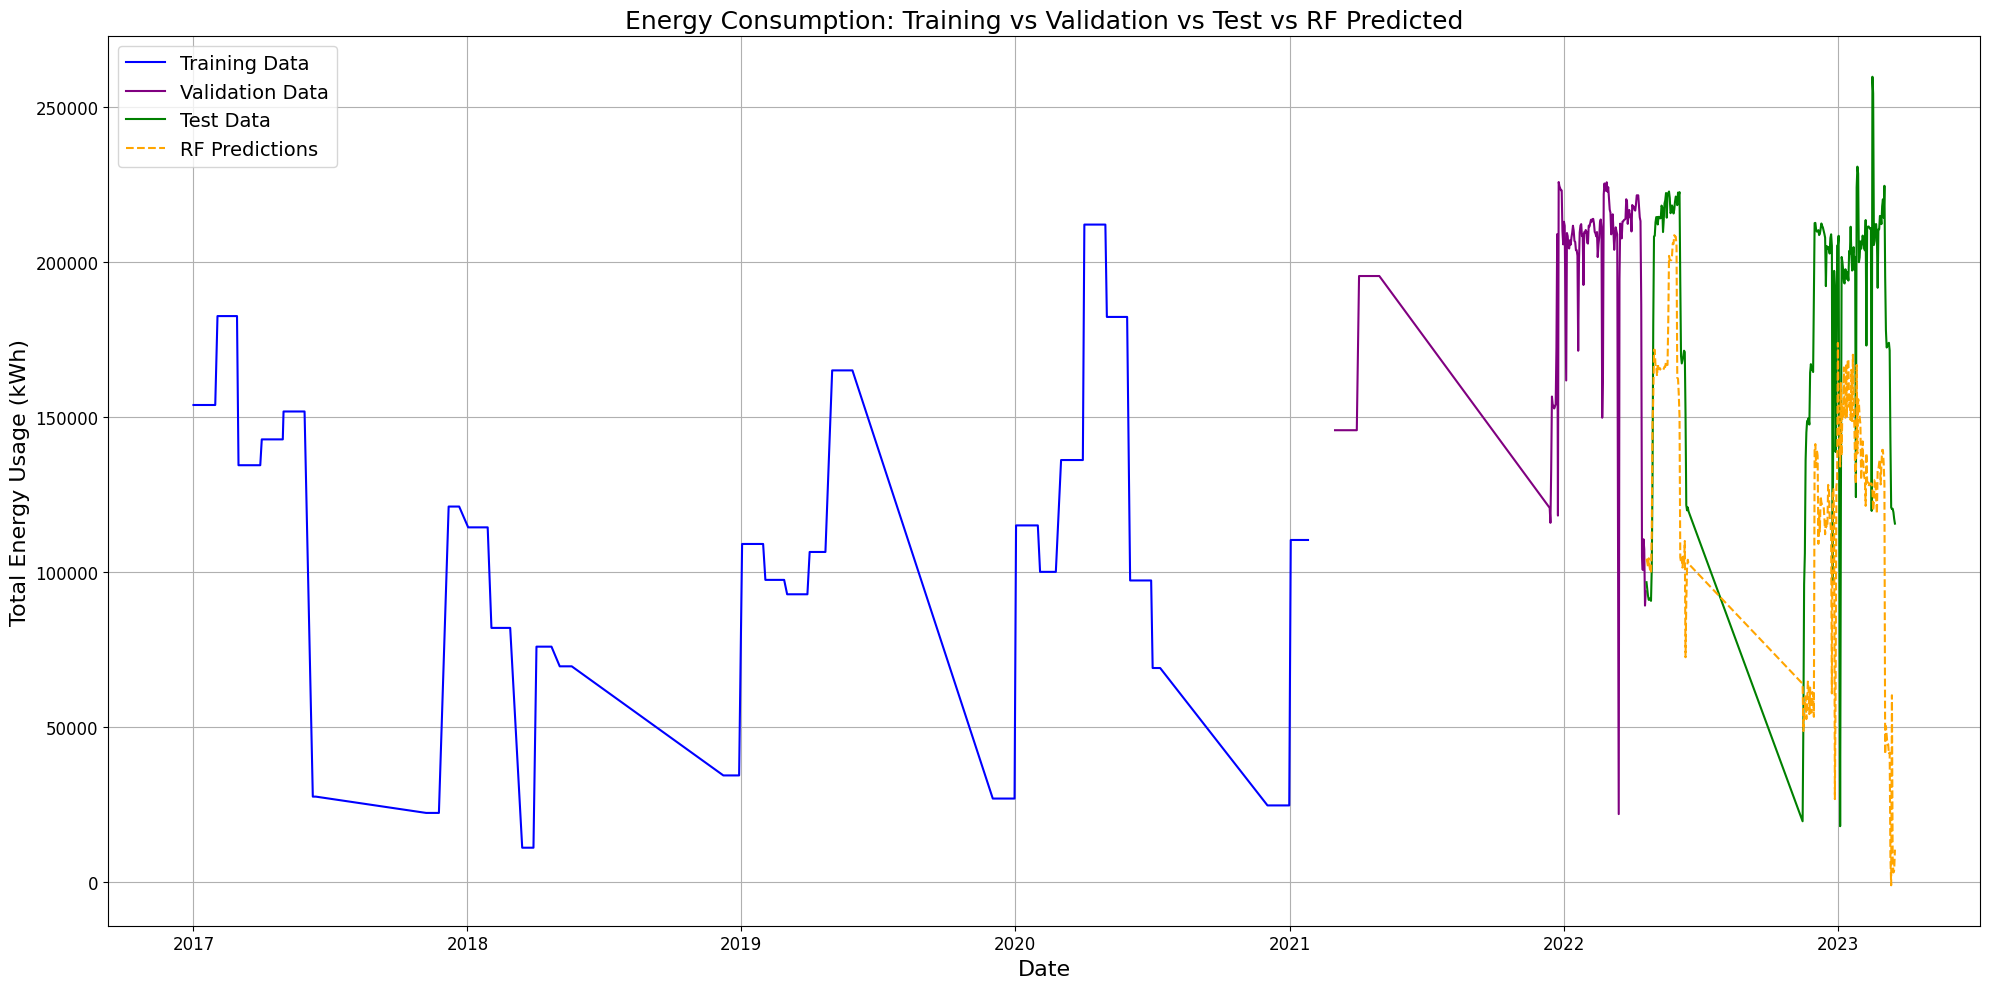

In [ ]:
import matplotlib.pyplot as plt

# Plotting function for Energy Consumption data using RF predictions
def plot_energy_gb_predictions(data, y_train, y_validation, y_test, y_pred_rf):
    plt.figure(figsize=(20, 10))

    # Calculate indices for train, validation, and test data for correct plotting
    train_indices = data['Date'][:len(y_train)]
    validation_indices = data['Date'][len(y_train):len(y_train) + len(y_validation)]
    test_indices = data['Date'][len(y_train) + len(y_validation):len(y_train) + len(y_validation) + len(y_test)]

    # Plot Training Data
    plt.plot(train_indices, y_train, label='Training Data', color='blue')

    # Plot Validation Data
    plt.plot(validation_indices, y_validation, label='Validation Data', color='purple')

    # Plot Test Data
    plt.plot(test_indices, y_test, label='Test Data', color='green')

    # Overlay Predicted Data (RF predictions for test data)
    plt.plot(test_indices, y_pred_rf, label='RF Predictions', color='orange', linestyle='--')

    # Add titles, labels, and legend with increased font sizes
    plt.title('Energy Consumption: Training vs Validation vs Test vs RF Predicted', fontsize=18)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Total Energy Usage (kWh)', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True)

    # Increase the size of tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Assuming y_pred_rf_energy contains the RF predictions for the test set, call the function:
y_pred_gb_energy = best_gb_energy.predict(X_test_actual)
plot_energy_gb_predictions(data, y_train_energy_actual, y_validation_energy_actual, y_test_energy_actual, y_pred_gb_energy)


# 5 Years Prediction From the Best Models for Treated Water and Energy Consumption

In [ ]:
import random

# Initialize lists to store predictions
treated_predictions = []
energy_predictions = []

In [ ]:
# Number of loops needed to reach 1825 predictions
n_loops = 1825 // len(X_train_actual)  # Integer division to get full loops
remaining_rows = 1825 % len(X_train_actual)  # Remaining rows after full loops

In [ ]:
# Loop through and concatenate the DataFrame with itself
X_future = pd.concat([X_train_actual] * n_loops, ignore_index=True)

In [ ]:
# Add the remaining rows
if remaining_rows > 0:
    X_future = pd.concat([X_future, X_train_actual.iloc[:remaining_rows]], ignore_index=True)

In [ ]:
# Make the predictions using the GB models
pred_treated = best_rf_treated.predict(X_future)
pred_energy = best_gb_energy.predict(X_future)

# Append the predictions to the lists
treated_predictions.extend(pred_treated)
energy_predictions.extend(pred_energy)


In [ ]:
# Convert predictions to DataFrame
pred_df = pd.DataFrame({
    'Treated_Water_Predictions': treated_predictions,
    'Energy_Consumption_Predictions': energy_predictions
})

In [ ]:
# Generate a date column
last_date = pd.to_datetime(data['Date'].iloc[-1])
future_dates = pd.date_range(start=last_date, periods=len(treated_predictions) + 1, freq='D')[1:]

In [ ]:
# Add the 'Date' column and rearrange it to be the first column
pred_df['Date'] = future_dates
pred_df = pred_df[['Date', 'Treated_Water_Predictions', 'Energy_Consumption_Predictions']]

In [ ]:
# Export to CSV
pred_df.to_csv('Future_Predictions.csv', index=False)

print("Predictions exported to Future_Predictions.csv")

Predictions exported to Future_Predictions.csv


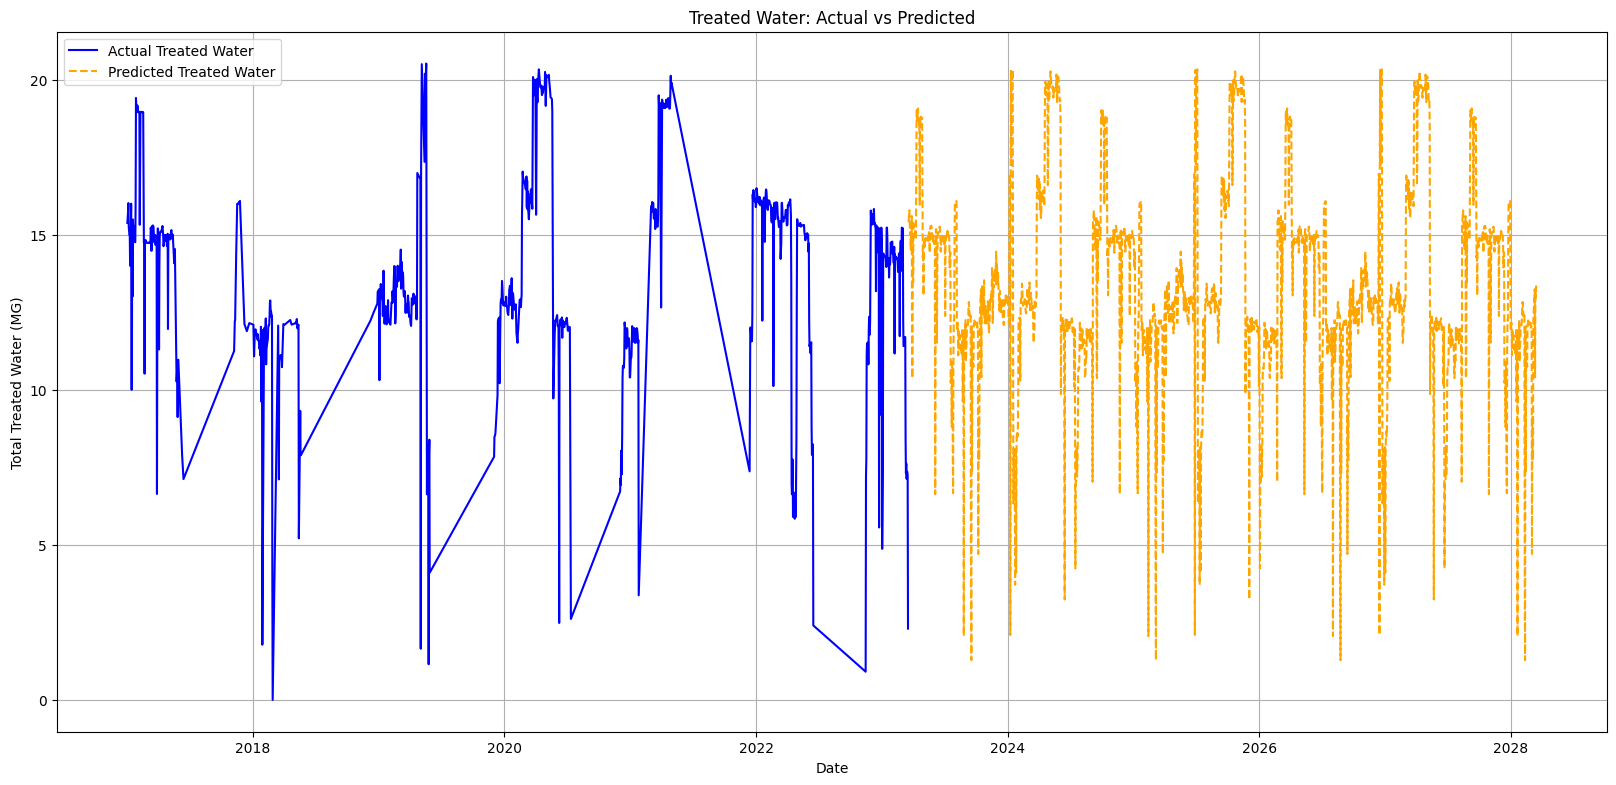

In [ ]:
# Set the figure size
plt.figure(figsize=(20, 20))

# Plot Actual Treated Water
plt.subplot(2, 1, 1)

# Plot the training and test data (actual values)
plt.plot(data['Date'], data['TotalTreated water leaving plant,MG'], label='Actual Treated Water', color='blue')

# Overlay the test data predictions
plt.plot(pred_df['Date'], pred_df['Treated_Water_Predictions'], label='Predicted Treated Water', color='orange', linestyle='--')

plt.title('Treated Water: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Total Treated Water (MG)')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig("Predicted Treated water for Tampa Site.png", dpi=300, bbox_inches='tight')

plt.show()


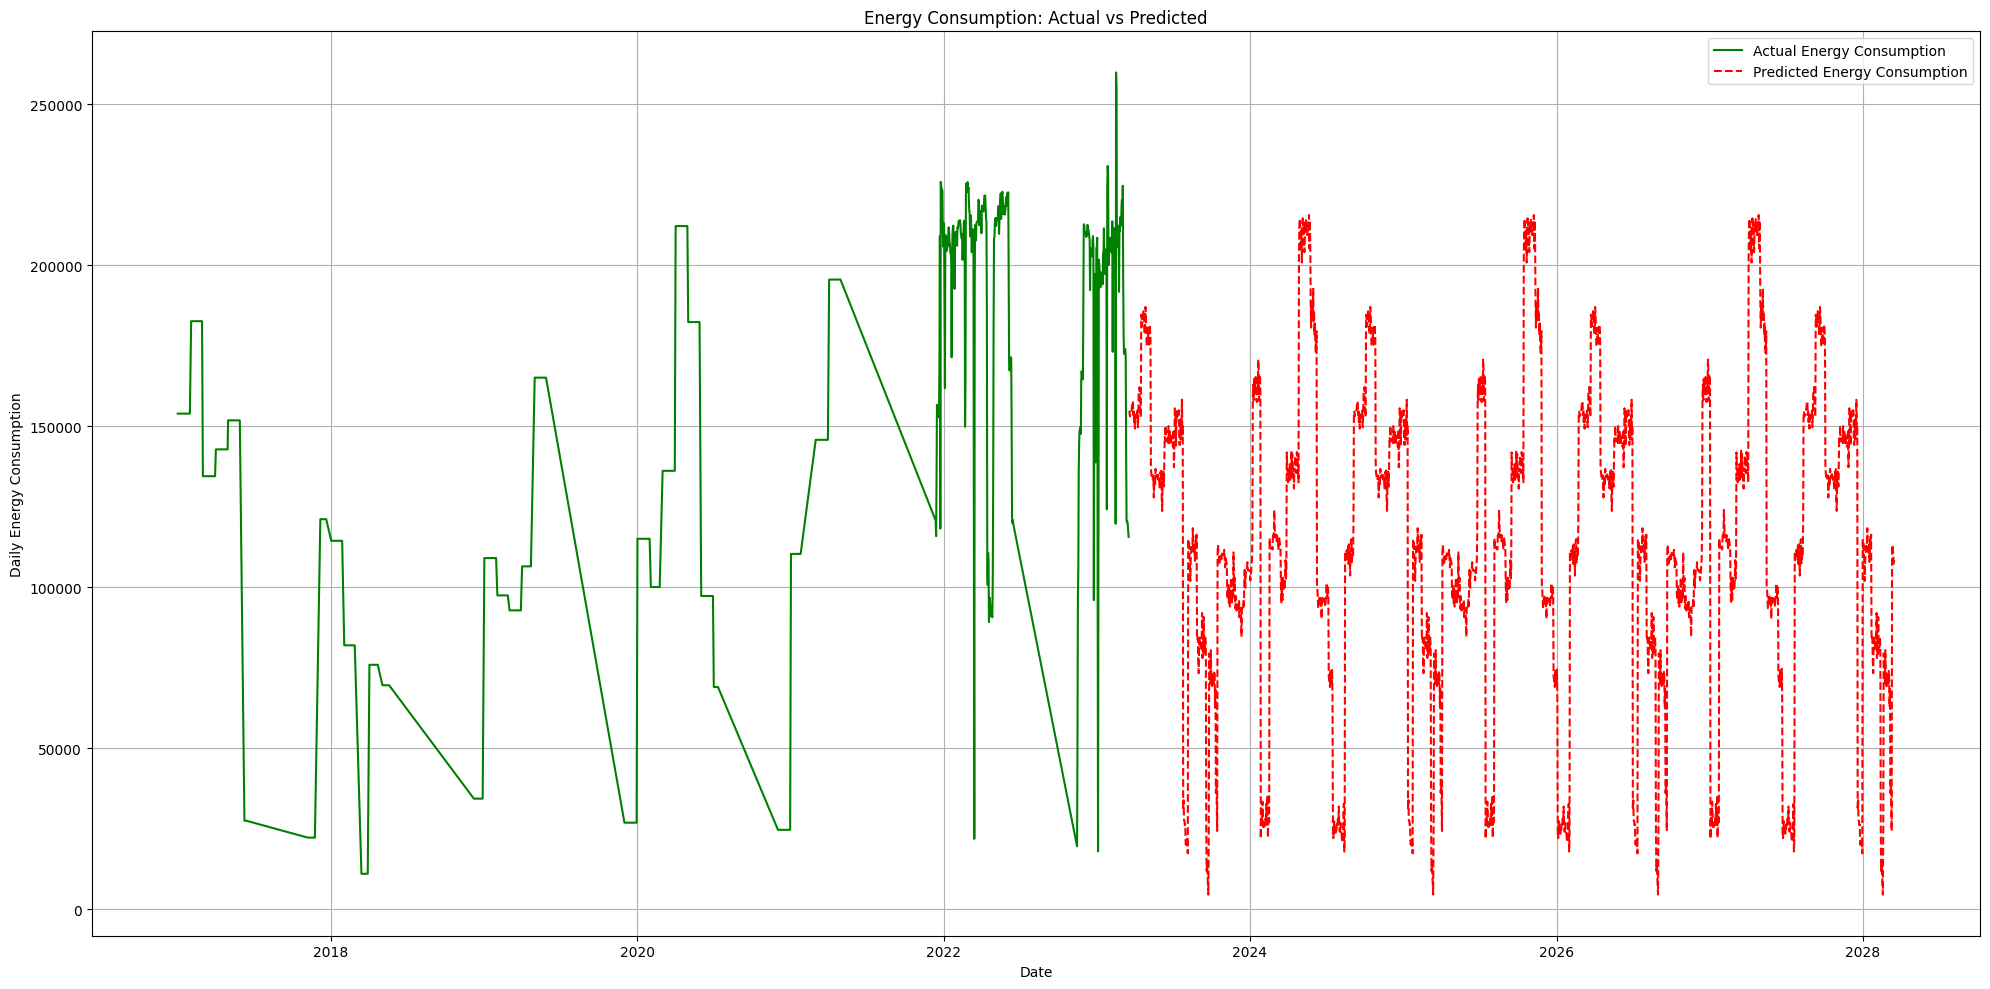

In [ ]:
# Set the figure size
plt.figure(figsize=(20, 10))

# Plot Training + Test Data for Actual Energy Consumption
plt.plot(data['Date'], data['Adjusted Daily Consumption, Kwh'], label='Actual Energy Consumption', color='green')

# Overlay Predicted Energy Consumption for Test Data
plt.plot(pred_df['Date'], pred_df['Energy_Consumption_Predictions'], label='Predicted Energy Consumption', color='red', linestyle='--')

# Add titles, labels, and legend
plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Daily Energy Consumption')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pickle

# Saving the Gradient Boosting model for treated water in Tampa
with open('rf_model_treated_tampa.pkl', 'wb') as f:
    pickle.dump(best_rf_treated, f)

# Saving the Gradient Boosting model for energy consumption
with open('best_gb_model_energy_tampa.pkl', 'wb') as f:
    pickle.dump(best_gb_energy, f)


In [ ]:
# Loading the Gradient Boosting model for treated water
with open('gb_model_treated_tampa.pkl', 'rb') as f:
    loaded_gb_model_treated_tampa = pickle.load(f)

# Loading the Gradient Boosting model for energy consumption
with open('gb_model_energy_tampa.pkl', 'rb') as f:
    loaded_gb_model_energy_tampa = pickle.load(f)


FileNotFoundError: [Errno 2] No such file or directory: 'gb_model_treated_tampa.pkl'